# User Guide

The SMOS data store is an xcube plugin that provides SMOS datasets
through the xcube data store interface. You first obtain an instance
of the SMOS data store, then you use this store instance to retrieve 
customised SMOS datasets tailored to your needs.

## Obtaining the Data Store

After [installation](start.md#installation) and once you have your 
[credentials](start.md#credentials) at hand, you can obtain an instance 
of the SMOS data store by its name `"smos"` and using the xcube function 
`new_data_store()` function. (Many other xcube data stores can be used in 
the same way, refer to the 
[xcube documentation](https://xcube.readthedocs.io/en/latest/dataaccess.html) 
for more information).
In the following it is assumed that the environment variables `CREODIAS_S3_KEY` 
and `CREODIAS_S3_SECRET` have been set:

In [17]:
from xcube.core.store import new_data_store

store = new_data_store("smos", cache_path="./nc_cache")

The data store parameters you can pass to the `new_data_store()` function depend on the
data store identifier used. For the data store named  `"smos"` the following arguments
can be provided:

* `cache_path`: _str_ - Path to local cache directory for raw, remote SMOS files.
   Useful if you work on a known temporal subset of SMOS data.
   A file in the local cache does not need to be fetched from remote.
* `source_path`: _str_ - Path or URL into SMOS archive filesystem. 
* `source_protocol`: _str_ - Protocol name for the SMOS archive filesystem. 
* `source_storage_options`: _dict_ - Storage options for the SMOS archive filesystem. 
* `xarray_kwargs`: _dict_ - Extra keyword arguments accepted by xarray.open_dataset. 
* `**source_storage_options_kwargs` - keyword-argument form of `source_storage_options` 

Because of `**source_storage_options_kwargs` you can pass storage options directly to the
`new_data_store()` call, such as:

* `key`: _str_ - Access key identifier for the CREODIAS storage,
  defaults to value of environment variable `CREODIAS_S3_KEY`.
* `secret`: _str_ - Secret access key for the CREODIAS storage,
  defaults to value of environment variable `CREODIAS_S3_SECRET`.

## Data Access

All xcube data stores provide a `store.open_data()` method to access 
the data. It has one required positional argument `data_id` which identifies 
the data(set) to be opened. The SMOS store provides two datasets, they are

* `"SMOS-L2C-SM"` - SMOS Level-2C Soil Moisture
* `"SMOS-L2C-OS"` - SMOS Level-2C Ocean Salinity

In addition  to the first `data_id` argument the following keyword 
arguments are defined:

* `time_range`: 
  The time range `(start, stop)` given as pair of start and stop dates 
  either as `tuple` or `list` of `str`. 
  Dates must be given using format `"YYYY-MM-DD"`. 
  Start and stop are inclusive. This parameter is required.
* `bbox`: Bounding box in geographical coordinates given as `(x1,y1, x2,y2)` 
  either as `tuple` or `list` of `float`. Defaults to global coverage
  resulting in a spatial image resolution of 8192 x 4032 pixels.
* `res_level`: Spatial resolution level in the range 0 to 4. 
  Actual resolution in degrees is `(360/8192) / 2 ** res_level`. 
  Defaults to `0`. 
  Not applicable to multi-resolution datasets, see below.
* `l2_product_cache_size`: Size of the SMOS L2 product cache given as 
  maximum number of SMOS L2 products to be cached in memory.
  Can drastically improve performance if you need to randomly access
  datacubes in the time dimension.
  Does not apply to dataset iterators, see below.

### Datasets

To get a dataset from the data store, you must pass its dataset identifier and
the time range, other parameters are optional. 

In [ ]:
# First we let xarray render datasets as text.
# Done for documentation generation only.
import xarray as xr
xr.set_options(display_style="text")

Here the Soil Moisture dataset is opened for a 2-day coverage:

In [3]:
sm_ds = store.open_data("SMOS-L2C-SM", 
                        time_range=["2024-01-01", "2024-01-02"])
sm_ds

<xarray.Dataset> Size: 29GB
Dimensions:            (time: 31, lat: 4032, lon: 8192, bnds: 2)
Coordinates:
  * lat                (lat) float64 32kB 88.57 88.53 88.48 ... -88.53 -88.57
  * lon                (lon) float64 66kB -180.0 -179.9 -179.9 ... 179.9 180.0
  * time               (time) datetime64[ns] 248B 2024-01-01T00:27:26.980000 ...
    time_bnds          (time, bnds) datetime64[ns] 496B dask.array<chunksize=(31, 2), meta=np.ndarray>
Dimensions without coordinates: bnds
Data variables:
    Chi_2              (time, lat, lon) float32 4GB dask.array<chunksize=(1, 4032, 8192), meta=np.ndarray>
    Chi_2_P            (time, lat, lon) float32 4GB dask.array<chunksize=(1, 4032, 8192), meta=np.ndarray>
    N_RFI_X            (time, lat, lon) float32 4GB dask.array<chunksize=(1, 4032, 8192), meta=np.ndarray>
    N_RFI_Y            (time, lat, lon) float32 4GB dask.array<chunksize=(1, 4032, 8192), meta=np.ndarray>
    RFI_Prob           (time, lat, lon) float32 4GB dask.array<chunksize=(1, 4032, 8192), meta=np.ndarray>
    Soil_Moisture      (time, lat, lon) float32 4GB dask.array<chunksize=(1, 4032, 8192), meta=np.ndarray>
    Soil_Moisture_DQX  (time, lat, lon) float32 4GB dask.array<chunksize=(1, 4032, 8192), meta=np.ndarray>

In [4]:
sm_ds.Soil_Moisture

<xarray.DataArray 'Soil_Moisture' (time: 31, lat: 4032, lon: 8192)> Size: 4GB
dask.array<open_dataset-Soil_Moisture, shape=(31, 4032, 8192), dtype=float32, chunksize=(1, 4032, 8192), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float64 32kB 88.57 88.53 88.48 88.44 ... -88.48 -88.53 -88.57
  * lon      (lon) float64 66kB -180.0 -179.9 -179.9 ... 179.9 179.9 180.0
  * time     (time) datetime64[ns] 248B 2024-01-01T00:27:26.980000 ... 2024-0...
Attributes:
    units:    m3 m-3

The SMOS data store does not perform any data aggregation in the `time` dimension. 
The SMOS satellite completes one orbit approximately every 100.1 minutes, that's
why there are around 30 time steps included in a 2-day coverage. A single time step
contains data of only a half orbit:

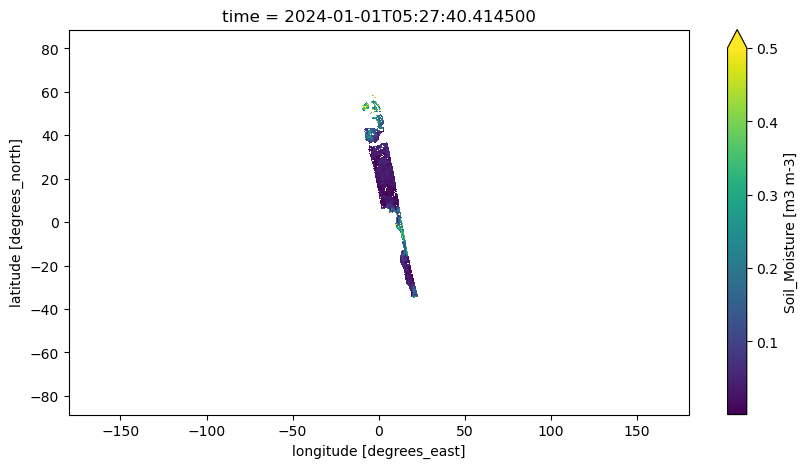

In [5]:
sm_ds.Soil_Moisture.isel(time=4).plot.imshow(figsize=(10, 5), vmax=0.5)

All orbits aggregated:

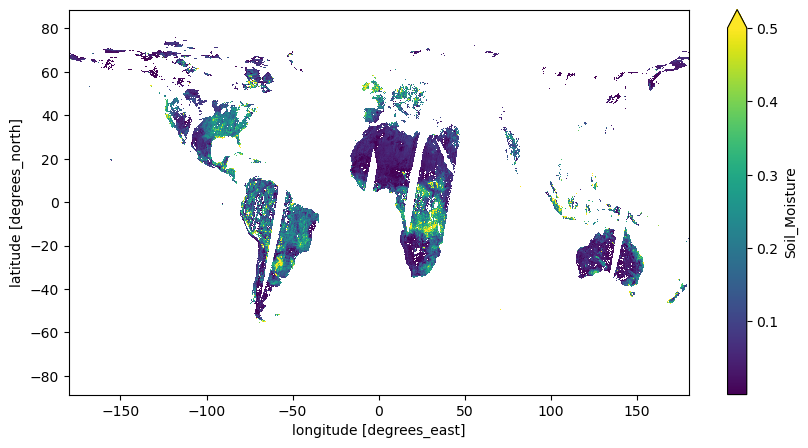

In [6]:
sm_ds.Soil_Moisture.mean("time").plot.imshow(figsize=(10, 5), vmax=0.5)

Same for an Ocean Salinity dataset:

In [7]:
os_ds = store.open_data("SMOS-L2C-OS", 
                        time_range=["2024-01-01", "2024-01-02"])
os_ds

<xarray.Dataset> Size: 44GB
Dimensions:              (time: 28, lat: 4032, lon: 8192, bnds: 2)
Coordinates:
  * lat                  (lat) float64 32kB 88.57 88.53 88.48 ... -88.53 -88.57
  * lon                  (lon) float64 66kB -180.0 -179.9 -179.9 ... 179.9 180.0
  * time                 (time) datetime64[ns] 224B 2024-01-01T01:17:31.81900...
    time_bnds            (time, bnds) datetime64[ns] 448B dask.array<chunksize=(28, 2), meta=np.ndarray>
Dimensions without coordinates: bnds
Data variables:
    Coast_distance       (time, lat, lon) float32 4GB dask.array<chunksize=(1, 4032, 8192), meta=np.ndarray>
    Dg_RFI_X             (time, lat, lon) float32 4GB dask.array<chunksize=(1, 4032, 8192), meta=np.ndarray>
    Dg_RFI_Y             (time, lat, lon) float32 4GB dask.array<chunksize=(1, 4032, 8192), meta=np.ndarray>
    Dg_chi2_corr         (time, lat, lon) float32 4GB dask.array<chunksize=(1, 4032, 8192), meta=np.ndarray>
    Dg_quality_SSS_anom  (time, lat, lon) float32 4GB dask.array<chunksize=(1, 4032, 8192), meta=np.ndarray>
    Dg_quality_SSS_corr  (time, lat, lon) float32 4GB dask.array<chunksize=(1, 4032, 8192), meta=np.ndarray>
    Mean_acq_time        (time, lat, lon) float32 4GB dask.array<chunksize=(1, 4032, 8192), meta=np.ndarray>
    SSS_anom             (time, lat, lon) float32 4GB dask.array<chunksize=(1, 4032, 8192), meta=np.ndarray>
    SSS_corr             (time, lat, lon) float32 4GB dask.array<chunksize=(1, 4032, 8192), meta=np.ndarray>
    Sigma_SSS_anom       (time, lat, lon) float32 4GB dask.array<chunksize=(1, 4032, 8192), meta=np.ndarray>
    Sigma_SSS_corr       (time, lat, lon) float32 4GB dask.array<chunksize=(1, 4032, 8192), meta=np.ndarray>
    X_swath              (time, lat, lon) float32 4GB dask.array<chunksize=(1, 4032, 8192), meta=np.ndarray>

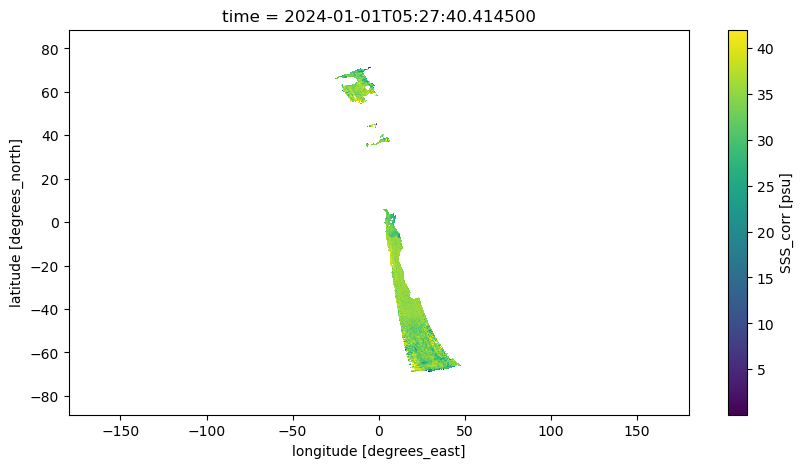

In [8]:
os_ds.SSS_corr.isel(time=3).plot.imshow(figsize=(10, 5))

Zoomed:

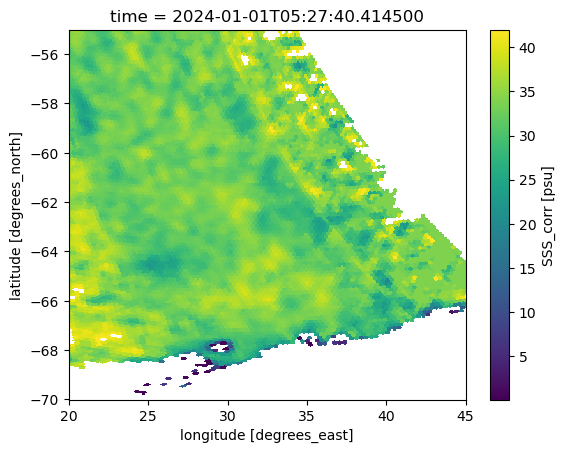

In [9]:
os_ds.SSS_corr.isel(time=3).sel(lon=slice(20, 45), lat=slice(-55, -70)).plot.imshow()

### Dataset Iterators

Use `opener_id="smosdsiter:zarr:smos"` to receive SMOS data in form of an
iterator of datasets of type `xarray.Dataset`. The returned datasets are 
iterated through the `time` dimension, hence individual datasets have a 
`time` dimension of size one.

In [10]:
ds_iter = store.open_data("SMOS-L2C-OS", 
                          opener_id="smosdsiter:zarr:smos",
                          time_range=["2024-01-01", "2024-01-02"])
ds_iter

The main use case of dataset iterators is persisting large datacubes
by subsequently appending slice dataset along the `time` dimension
at stable memory and CPU consumption. For example, you can use the 
[zappend](https://bcdev.github.io/zappend/) tool to write larger 
datacubes like this:

```python
zappend(ds_iter, target_dir="SMOS-L2C-OC.zarr")
```

### Multi-Resolution Datasets

Use `opener_id="mldataset:zarr:smos"` to receive SMOS data in form of a multi-resolution dataset:

In [11]:
ml_ds = store.open_data("SMOS-L2C-OS", 
                        opener_id="mldataset:zarr:smos",
                        time_range=["2024-01-01", "2024-01-02"])
ml_ds

The returned multi-resolution dataset `ml_ds` is just a container for 
ordinary datasets oy type `xarray.Dataset` at different spatial 
resolutions:

In [12]:
for level in range(ml_ds.num_levels):
    ds = ml_ds.get_dataset(level)
    print(f"Level {level}: {ds.sizes}")

Level 0: Frozen({'time': 28, 'lat': 4032, 'lon': 8192, 'bnds': 2})
Level 1: Frozen({'time': 28, 'lat': 2016, 'lon': 4096, 'bnds': 2})
Level 2: Frozen({'time': 28, 'lat': 1008, 'lon': 2048, 'bnds': 2})
Level 3: Frozen({'time': 28, 'lat': 504, 'lon': 1024, 'bnds': 2})
Level 4: Frozen({'time': 28, 'lat': 252, 'lon': 512, 'bnds': 2})


## Parameter Schemas

This section describes how the various parameters used by SMOS data store
can be inspected programmatically.

### Schema for the Data Store Parameters

The xcube function `get_data_store_params_schema()` outputs the allowed parameters 
for a given data store as a JSON Schema object:

In [13]:
from xcube.core.store import get_data_store_params_schema

schema = get_data_store_params_schema("smos")
schema

In [14]:
# For example:
for p_name, p_schema in schema.properties.items():
    print(f"* `{p_name}: {p_schema.type} - {p_schema.description or p_schema.title}")

* `source_path: string - Path or URL into SMOS archive filesystem.
* `source_protocol: string - Protocol name for the SMOS archive filesystem.
* `source_storage_options: object - See fsspec documentation for specific filesystems.
* `cache_path: string - Path to local cache directory. Must be given, if file caching is desired.
* `xarray_kwargs: object - See xarray documentation for allowed keywords.


You can use `schema.to_dict()` get a JSON-serializable dictionary.

### Schema for the Open Parameters

Using the `store.get_open_data_params_schema()` method you can inspect 
the allowed parameters for the `store.open_data()` method, which is 
used to open SMOS datacubes.

In [15]:
schema = store.get_open_data_params_schema(opener_id="dataset:zarr:smos")
schema

In [16]:
for p_name, p_schema in schema.properties.items():
    print(f"* `{p_name}: {p_schema.type} - {p_schema.description or p_schema.title}")

* `time_range: array - Time range given as pair of start and stop dates. Dates must be given using format 'YYYY-MM-DD'. Start and stop are inclusive.
* `bbox: array - Bounding box [x1,y1, x2,y2] in geographical coordinates
* `res_level: integer - Spatial resolution level in the range 0 to 4. Zero refers to the max. resolution of 0.0439453125 degrees.
